In [1]:
import pandas as pd

path = 'C:/Users/2093/Desktop/Data Center/03. Data/05. TAITRA/FCRM/data/'
df = pd.read_csv(path + 'inquiry_utf8.csv')

def parse_date_column(s):
    """Take a Series and return a datetime-parsed Series."""
    
    dates = s.str.extract(r'(\d{2})-(\d{1,2})月 *-(\d{2})', expand=True)
    nineties = dates.iloc[:, 2].str.contains(r'8\d{1}|9\d{1}', na=False)
    millennium = dates.iloc[:, 2].str.contains(r'0\d{1}|1\d{1}', na=False)
    dates.loc[nineties, 2] = '19' + dates.loc[nineties, 2]
    dates.loc[millennium, 2] = '20' + dates.loc[millennium, 2]
    dates = pd.to_datetime(dates[0] + '-' + dates[1] + '-' + dates[2], format='%d-%m-%Y')
    return dates

for col in ['CREATION_DATE', 'LAST_UPDATE_DATE', 'PASSED_DATE']:
    df[col] = parse_date_column(df[col])

C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3,10,14,15,16,17,18,25,26,28,30,34,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


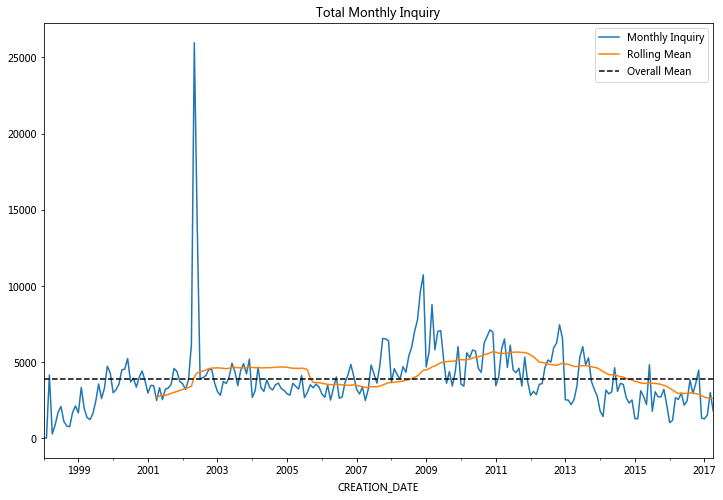

In [2]:
import matplotlib.pyplot as plt

monthly_inq = df.set_index('CREATION_DATE').loc['1998':, 'OID'].resample('M').count()

plt.figure(figsize=(12, 8))
monthly_inq.plot()
monthly_inq.rolling(window=40).mean().plot()
plt.axhline(monthly_inq.mean(), color='k', linestyle='dashed')
plt.title('Total Monthly Inquiry')
plt.legend(['Monthly Inquiry', 'Rolling Mean', 'Overall Mean'])
plt.savefig('monthly_inq.jpg', dpi=300)
plt.show()

In [3]:
(pd.concat([df.fillna(method='bfill').iloc[1, :], df.notnull().sum() / len(df) * 100], axis=1)
 .sort_values(0, ascending=False))

,1,0
OID,171,100.000000
CREATION_DATE,1999-08-27 00:00:00,100.000000
PRODUCT_CATEGORY_OID,950,100.000000
STATUS,PUBLISH,100.000000
COMPANY_OID,39475,99.985813
PRODUCT_NAME,Women's or girls' garments.,99.965973
CREATION_DEPT_OID,NY,99.902130
LAST_UPDATE_DATE,2000-01-01 00:00:00,99.738312
OFFER_EXPIRATION_DATE,27-11月-99,99.690874
VERIFY_YN,Y,99.556871


In [4]:
%%time

import string
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def process_string(s):
    processed = (s.str.strip()
                  .str.lower()
                  .str.replace(r'[\t\n\r\f\v]', r'')
                  .apply(lambda s: s.translate(str.maketrans({x: None for x in string.punctuation}))
                         if type(s) == str else np.nan)
                  .apply(lambda s: ' '.join([wnl.lemmatize(x) for x in s.split(' ') if x not in stopwords.words('english')])
                         if type(s) == str else np.nan)
                  .str.replace(r' +', r' '))
    return processed

df['PRODUCT_NAME'] = process_string(df['PRODUCT_NAME'])
df['SPECIFICATION'] = process_string(df['SPECIFICATION'])

Wall time: 21min 46s


In [5]:
pd.Series(' '.join(df['PRODUCT_NAME'].dropna()).split(' ')).value_counts().head(20)

product       58425
machine       50553
part          36557
equipment     32033
car           31649
machinery     24742
care          24291
plastic       23619
accessory     22391
computer      22379
system        19736
tool          18110
material      13984
food          13459
bicycle       12607
steel         12254
electronic    10920
furniture     10280
metal         10211
automobile     9543
dtype: int64

In [6]:
dept = pd.read_csv('C:/Users/2093/Desktop/Data Center/03. Data/05. TAITRA/FCRM/department.csv')
df = df.merge(dept, left_on='CREATION_DEPT_OID', right_on='DEPTID')

ttc = (r'.*台灣貿易中心.*|.*臺灣貿易中心.*|.*台貿中心.*|.*台北貿易中心.*|.*駐留辦公室.*|.*駐留辦事處.*|'
       + '.*[^化岸]辦事處$')  # exclude 台北經濟文化辦事處, 遠東貿易服務中心駐象牙海岸辦事處
gov = (r'.*大使館.*|.*代表處經濟組.*|.*辦事處經濟組.*|.*辦事處商務組.*|.*服務處.*|.*商務組.*|'
       + '.*台北經濟文化辦事處.*|遠東貿易服務中心駐象牙海岸辦事處')
nc = r'.*網路行銷中心.*'
md = r'.*市場開發處.*|.*市場拓展處.*|.*貿易尖兵.*'
sm = r'.*行銷專案處.*'
ed = r'.*展覽業務處.*'
pf = r'.*企劃財務處.*'
it = r'.*資訊及數據中心.*'

df['dept_ctgy'] = df['NAME'].replace(
    [ttc, gov, nc, md, sm, ed, pf, it],
    ['台灣貿易中心', '經濟組', '網路中心', '拓展處', '行銷處', '展覽處', '企財處', '數據中心'],
    regex=True)

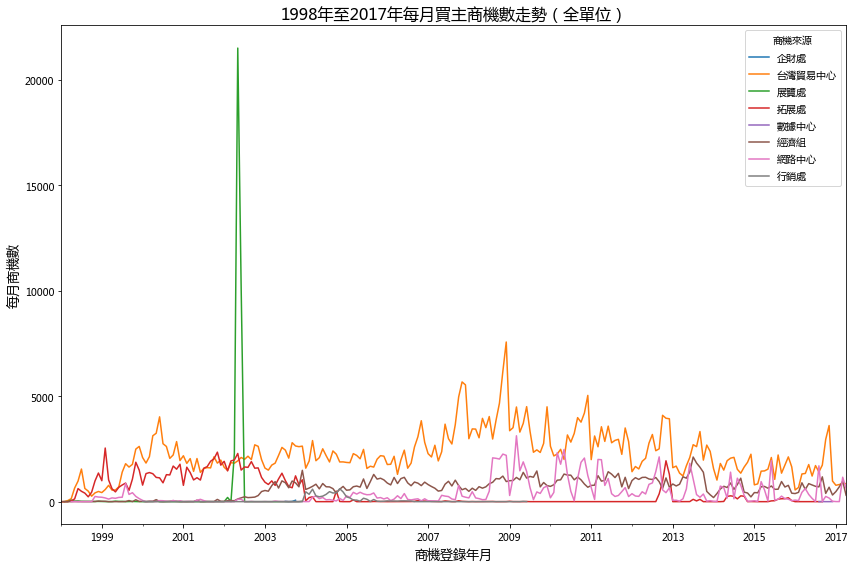

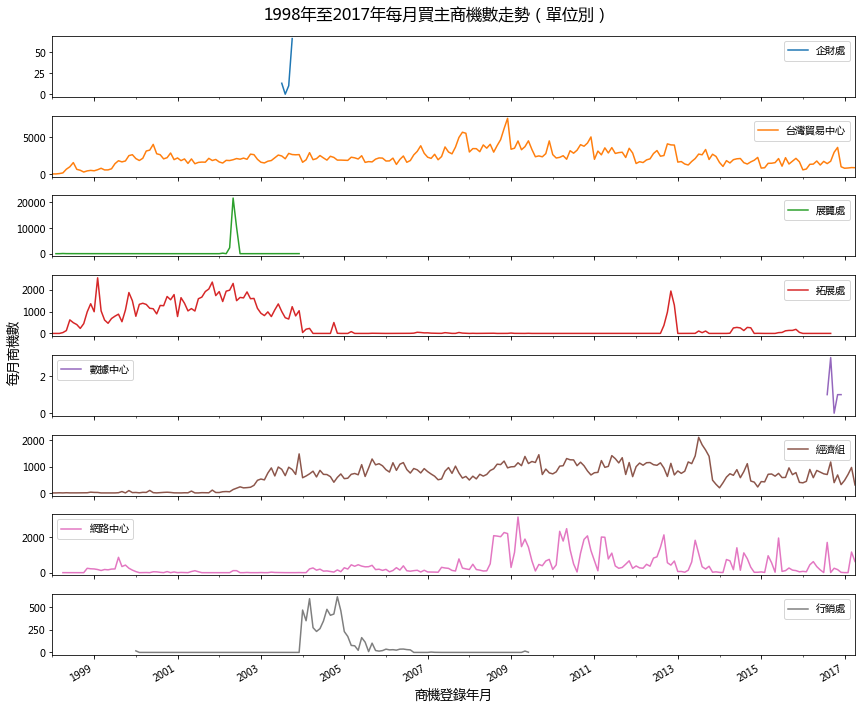

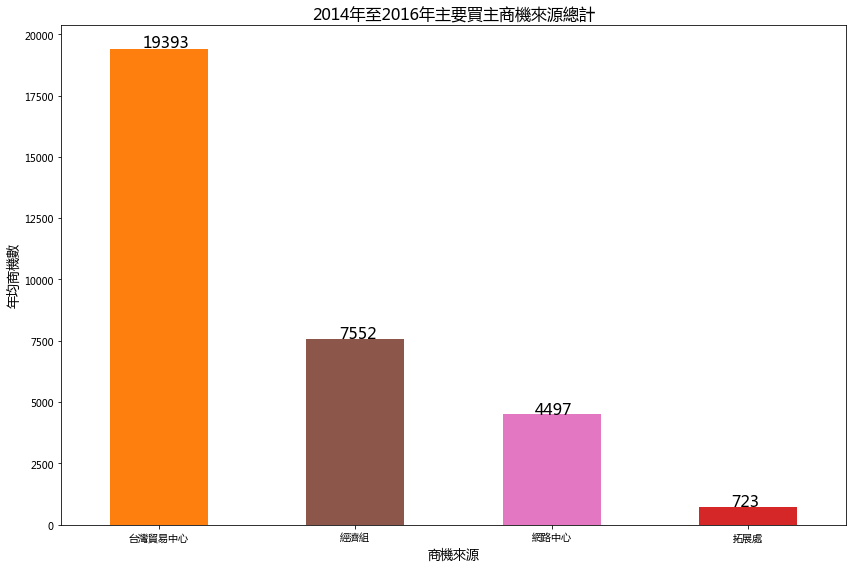

In [7]:
dept_cnt = (df.set_index('CREATION_DATE').groupby('dept_ctgy')['OID'].resample('M').count()
            .unstack('dept_ctgy').loc['1998':])

dept_cnt.plot(kind='line', figsize=(12, 8))
plt.title('1998年至2017年每月買主商機數走勢（全單位）', fontsize=16)
plt.xlabel('商機登錄年月', fontsize=13)
plt.ylabel('每月商機數', fontsize=13)
plt.legend(title='商機來源')
plt.tight_layout()
plt.savefig('monthly_inq_dept.jpg', dpi=300)
plt.show()

ax = dept_cnt.plot(kind='line', figsize=(12, 10), subplots=True)
plt.suptitle('1998年至2017年每月買主商機數走勢（單位別）', fontsize=16)
plt.xlabel('商機登錄年月', fontsize=13)
fig = ax[0].figure
fig.text(0.01, 0.5, '每月商機數', fontsize=13, ha='center', va='center', rotation=90)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.savefig('monthly_inq_dept_facet.jpg', dpi=300)
plt.show()

dept_mean = (df.set_index('CREATION_DATE').groupby('dept_ctgy')['OID'].resample('A').count()
             .unstack('dept_ctgy').loc['2014':'2016'].mean().sort_values(ascending=False).dropna().head(4))

fig, ax = plt.subplots()
dept_mean.plot(kind='bar', color=['C1', 'C5', 'C6', 'C3'], figsize=(12, 8), ax=ax)
for p in ax.patches:
    ax.annotate(str(round(p.get_height())), (p.get_x() + p.get_width() / 3, p.get_height() * 1.005),
                fontsize=16)
plt.title('2014年至2016年主要買主商機來源總計', fontsize=16)
plt.xlabel('商機來源', fontsize=13)
plt.ylabel('年均商機數', fontsize=13)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('main_inq_source.jpg', dpi=300)
plt.show()